In [1]:
from pathlib import Path

import cv2 as cv
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

import feature_detection

In [2]:
data_pth = op.join("images", "inhouse3")
focal_filename = "focal.txt"
img_set = []
focal_set = []
cy_img_set = []

In [3]:
def imshow(img, cmap=None):
    plt.imshow(img, cmap)
    plt.show()

images\inhouse3\DSC_0703.JPG


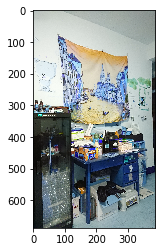

images\inhouse3\DSC_0704.JPG


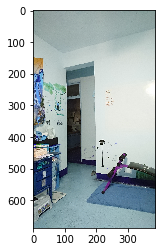

images\inhouse3\DSC_0705.JPG


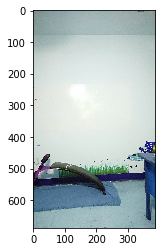

images\inhouse3\DSC_0706.JPG


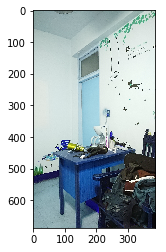

images\inhouse3\DSC_0707.JPG


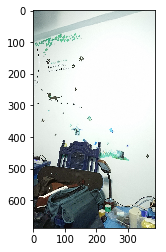

images\inhouse3\DSC_0708.JPG


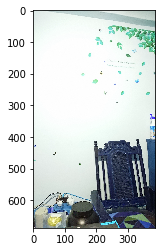

images\inhouse3\DSC_0709.JPG


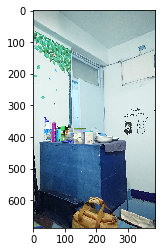

images\inhouse3\DSC_0710.JPG


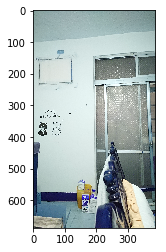

images\inhouse3\DSC_0711.JPG


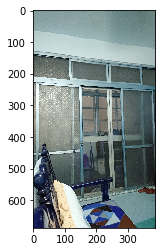

images\inhouse3\DSC_0712.JPG


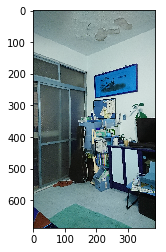

images\inhouse3\DSC_0713.JPG


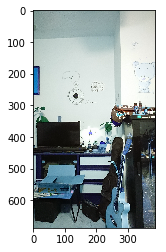

In [36]:
'''
# Resize block
for img_pth in sorted(Path(data_pth).glob(f'*.JPG')):
    print(img_pth)
    filename = op.basename(img_pth)
    img = cv.imread(op.join(img_pth))
    img = cv.resize(img, (round(img.shape[1]/8), round(img.shape[0]/8)), interpolation=cv.INTER_CUBIC)
    imshow(img)
    cv.imwrite(op.join(data_pth, "t" + filename), img)
'''

In [6]:
focal_set.clear()
with open(op.join(data_pth, focal_filename), "r") as f:
    for line in f.readlines():
        f = float(line.rstrip('\n'))
        focal_set.append(f)

images\inhouse3\tDSC_0703.JPG


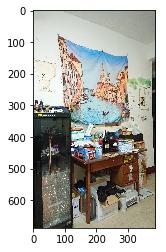

images\inhouse3\tDSC_0704.JPG


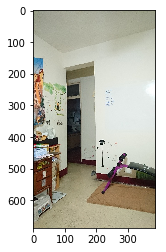

images\inhouse3\tDSC_0705.JPG


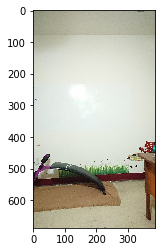

images\inhouse3\tDSC_0706.JPG


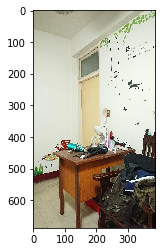

images\inhouse3\tDSC_0707.JPG


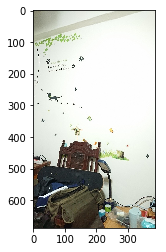

images\inhouse3\tDSC_0708.JPG


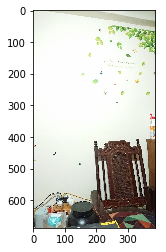

images\inhouse3\tDSC_0709.JPG


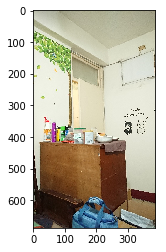

images\inhouse3\tDSC_0710.JPG


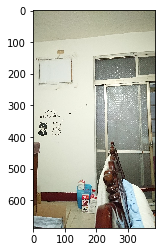

images\inhouse3\tDSC_0711.JPG


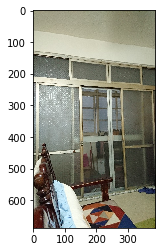

images\inhouse3\tDSC_0712.JPG


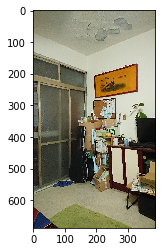

images\inhouse3\tDSC_0713.JPG


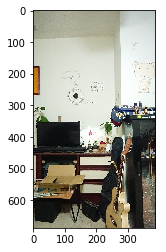

In [4]:
img_set.clear()
for img_pth in sorted(Path(data_pth).glob(f't*.JPG')):
    print(img_pth)
    img = cv.imread(op.join(img_pth))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (round(img.shape[1]), round(img.shape[0])), interpolation=cv.INTER_CUBIC)
    imshow(img)
    img_set.append(img)

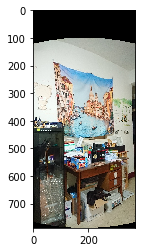

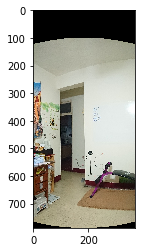

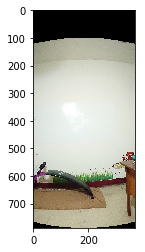

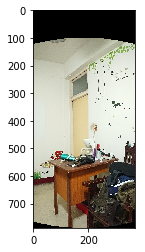

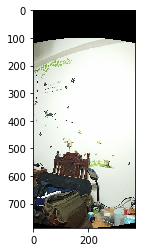

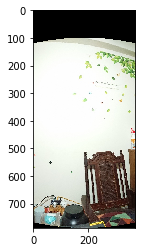

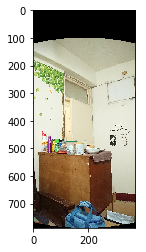

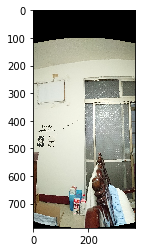

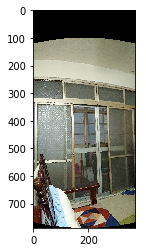

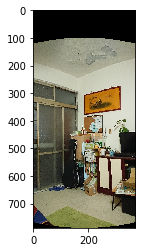

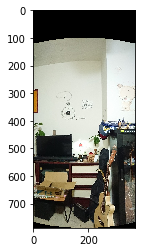

In [7]:
# to cylindrical coordinate
cy_img_set.clear()
for i, img in enumerate(img_set):
    f = focal_set[i]
    if f > 0:
        cy_img = np.zeros_like(img)
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                y_tmp = int(y - img.shape[0] / 2)
                x_tmp = int(x - img.shape[1] / 2)
                y_p = int(round(f * y_tmp / math.sqrt(x_tmp**2 + f**2)) + img.shape[0] / 2)
                x_p = int(round(f * math.atan(x_tmp/f)) + img.shape[1] / 2)
                cy_img[y_p][x_p] = img[y][x]
    else:
        cy_img = np.copy(img)
    # x~-x is to cancel the black boader, however, it should be calculate precisely by f and x above
    # Here is for convinent
    tmp_y = int(round(cy_img.shape[0] / 2))
    for x in range(cy_img.shape[1]):
        if cy_img[tmp_y][x][0] == 0.0:
            continue
        else:
            tmp_x = x
            break
    img_t = cy_img[:, tmp_x:-tmp_x, :]
    black_boader = int(round(img_t.shape[0] / 10))
    img_t = cv.copyMakeBorder(img_t, black_boader, black_boader, 0, 0, cv.BORDER_CONSTANT, value=[0, 0, 0])
    imshow(img_t)
    cy_img_set.append(img_t)

In [8]:
def feature_extraction(img):
    '''
    # feature extraction with library SIFT
    # Initiate SIFT detector
    sift = cv.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img,None)
    return kp1, des1
    '''
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    img_gray = np.array(img_gray)
    # Harris corner detector
    key_points, local_maxima = feature_detection.HarrisCornerDetector(img_gray)

    # MSOP descriptor
    key_points, descriptors = feature_detection.MSOPDescriptor(img_gray, key_points)

    return key_points, descriptors

In [9]:
def feature_matching(img1, img2, kp1, kp2, des1, de2):
    def take_last(elem):
        return elem[-1]
    def distance(p1, p2):
        return math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    n_compare_pts = 0
    compared_threshold = 1500
    kp_candidate = []
    for i, des in enumerate(des1):
        candidate_pt = []
        # Ignore the boarder
        if kp1[i][0] < 10 or kp1[i][0] > img1.shape[1] - 10 or kp1[i][1] < 10 or kp1[i][1] > img1.shape[0] - 10:
            continue
        for j, des_compare in enumerate(des2):
            # Ignore the boarder
            if kp2[j][0] < 10 or kp2[j][0] > img2.shape[1] - 10 or kp2[j][1] < 10 or kp2[j][1] > img2.shape[0] - 10:
                continue
            if sum(abs(des-des_compare)) < compared_threshold:
                candidate_pt.append([kp1[i], kp2[j], sum(abs(des-des_compare))])
        if len(candidate_pt) > 0:
            n_compare_pts += 1
            # if more than one: sorted to get the best one
            if(len(candidate_pt) > 1):
                candidate_pt.sort(key=take_last)
            kp_in_img1, kp_in_img2, _ = candidate_pt[0]
            kp_candidate.append([kp_in_img1, kp_in_img2])
    print("Compared candidate found with pairs:", n_compare_pts)

    approve_vote = 0
    max_approve_vote = 0
    candidate_index = -1
    for i, (kp_1, kp_2) in enumerate(kp_candidate):
        #print(kp_1.pt, kp_2.pt)
        x_translate = kp_1[0] - kp_2[0]
        y_translate = kp_1[1] - kp_2[1]
        #print(x_translate, y_translate)
        approve_vote = 0
        for kp_1_tmp, kp_2_tmp in kp_candidate:
            kp2_2_kp1 = (kp_2_tmp[0] + x_translate, kp_2_tmp[1] + y_translate)
            if distance(kp_1_tmp, kp2_2_kp1) < 5:
                approve_vote += 1
        if max_approve_vote < approve_vote:
            max_approve_vote = approve_vote
            candidate_index = i
    ransac_pt_list = []
    kp_1, kp_2 = kp_candidate[candidate_index]
    x_translate = kp_1[0] - kp_2[0]
    y_translate = kp_1[1] - kp_2[1]
    img1_ft = np.copy(img1)
    img2_ft = np.copy(img2)
    for kp_1_tmp, kp_2_tmp in kp_candidate:
        kp2_2_kp1 = (kp_2_tmp[0] + x_translate, kp_2_tmp[1] + y_translate)
        if distance(kp_1_tmp, kp2_2_kp1) < 5:
            ransac_pt_list.append([kp_1_tmp, kp_2_tmp])
            cv.circle(img1_ft, (int(round(kp_1_tmp[0])), int(round(kp_1_tmp[1]))), 2, (255, 0, 0), -1)
            cv.circle(img2_ft, (int(round(kp_2_tmp[0])), int(round(kp_2_tmp[1]))), 2, (255, 0, 0), -1)
    imshow(img1_ft)
    imshow(img2_ft)
    print(len(ransac_pt_list))
    return (x_translate, y_translate)

In [10]:
def image_concatenate(img1, img2, global_translate, shifted_y=0):
    img_t1 = np.copy(img1)
    img_t2 = np.copy(img2)
    #imshow(img_t1)
    #imshow(img_t2)
    print(global_translate, round(global_translate[0]), round(global_translate[1]))
    if round(global_translate[0]) < 0:
        shifted_x = int(abs(round(global_translate[0])))
        shifted_y = int(round(global_translate[1]) + shifted_y)
        M = np.float32([[1, 0, 0], [0, 1, shifted_y]])
        img_t2 = cv.warpAffine(img_t2, M, (img_t2.shape[1], img_t2.shape[0]))
        img_cat = cv.copyMakeBorder(img_t1, 0, 0, shifted_x, 0, cv.BORDER_CONSTANT, value=[0, 0, 0])
        middle_length = img_t2.shape[1] - shifted_x
        #print(img_t1.shape, img_t2.shape, img_cat.shape, shifted_x)
        #print(middle_length)
        # Blending with alpha ratio
        for y in range(img_cat.shape[0]):
            for x in range(img_cat.shape[1]):
                if x < shifted_x:
                    img_cat[y][x] = img_t2[y][x]
                elif x >= shifted_x and x < shifted_x + middle_length:
                    ratio = (x - shifted_x) / middle_length
                    # closer -> heavier
                    img_cat[y][x] = ratio * img_t1[y][x-shifted_x] + (1 - ratio) * img_t2[y][x]
                else:
                    img_cat[y][x] = img_t1[y][x-shifted_x]
    else:
        shifted_x = int(abs(round(global_translate[0])))
        shifted_y = int(round(global_translate[1]) + shifted_y)
        M = np.float32([[1, 0, 0], [0, 1, shifted_y]])
        img_t2 = cv.warpAffine(img_t2, M, (img_t2.shape[1], img_t2.shape[0]))
        img_cat = cv.copyMakeBorder(img_t1, 0, 0, 0, shifted_x, cv.BORDER_CONSTANT, value=[0, 0, 0])
        middle_length = img_t2.shape[1] - shifted_x
        #print(img_t1.shape, img_t2.shape, img_cat.shape, shifted_x)
        #print(middle_length)
        # Blending with alpha ratio
        for y in range(img_cat.shape[0]):
            for x in range(img_cat.shape[1]):
                if x < img_t1.shape[1] - middle_length:
                    img_cat[y][x] = img_t1[y][x]
                elif x >= img_t1.shape[1] - middle_length and x < img_t1.shape[1]:
                    ratio = (x - (img_t1.shape[1] - middle_length)) / middle_length
                    # closer -> heavier
                    img_cat[y][x] = ratio * img_t2[y][x-(img_t1.shape[1] - middle_length)] + (1 - ratio) * img_t1[y][x]
                else:
                    img_cat[y][x] = img_t2[y][x-(img_t1.shape[1] - middle_length)]
    imshow(img_cat)
    return img_cat, shifted_y

(13379, 2)
(4412, 2)
Compared candidate found with pairs:806


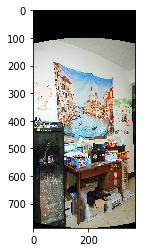

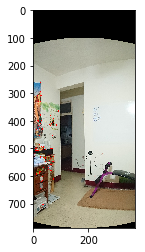

80
(261.13094058170265, -13.70392128818986)261.0-14.0


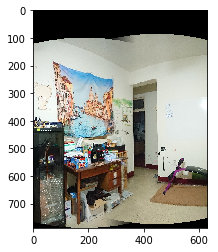

In [11]:
for i, img in enumerate(cy_img_set):
    if i == len(cy_img_set) - 1:
        break
    img_compared = cy_img_set[i+1]
    kp1, des1 = feature_extraction(img)
    kp2, des2 = feature_extraction(img_compared)

    # Swap x, y for different design; SIFT is (x, y) but in harris is (y, x)
    kp1[:, [0, 1]] = kp1[:, [1, 0]]
    kp2[:, [0, 1]] = kp2[:, [1, 0]]
    global_translate = feature_matching(img, img_compared, kp1, kp2, des1, des2)
    if i == 0:
        img_cat = img
        shifted_y = 0
    img_cat, shifted_y = image_concatenate(img_cat, img_compared, global_translate, shifted_y)
    break

In [33]:
img_cat_bgr = cv.cvtColor(img_cat, cv.COLOR_RGB2BGR)
cv.imwrite("pano1.jpg", img_cat_bgr)

True

-67(788, 2991, 3)


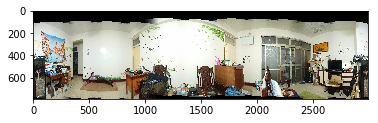

In [50]:
print(shifted_y, img_cat.shape)
img_cat_y_fix = np.copy(img_cat)
if round(global_translate[0]) < 0:
    if shifted_y < 0:
        for x in range(img_cat.shape[1]):
            ratio = 1 - (x / (img_cat.shape[1]))
            y_offset = abs(round(ratio * shifted_y))
            for y in range(img_cat.shape[0]):
                #if y > img_cat.shape[0] - y_offset: break
                if y < y_offset:
                    img_cat_y_fix[y][x] = [0, 0, 0]
                elif y >= y_offset:
                    img_cat_y_fix[y][x] = img_cat[y-y_offset][x]
    else:
        for x in range(img_cat.shape[1]):
            ratio = x / img_cat.shape[1]
            y_offset = abs(round(ratio * shifted_y))
            for y in range(img_cat.shape[0]):
                #if y > img_cat.shape[0] - y_offset: break
                if y < img_cat.shape[0] - y_offset:
                    img_cat_y_fix[y][x] = img_cat[y+y_offset][x]
                else:
                    img_cat_y_fix[y][x] = [0, 0, 0]
else:
    if shifted_y < 0:
        for x in range(img_cat.shape[1]):
            ratio = x / (img_cat.shape[1])
            y_offset = abs(round(ratio * shifted_y))
            for y in range(img_cat.shape[0]):
                #if y > img_cat.shape[0] - y_offset: break
                if y < y_offset:
                    img_cat_y_fix[y][x] = [0, 0, 0]
                elif y >= y_offset:
                    img_cat_y_fix[y][x] = img_cat[y-y_offset][x]
    else:
        for x in range(img_cat.shape[1]):
            ratio = 1 - (x / (img_cat.shape[1]))
            y_offset = abs(round(ratio * shifted_y))
            for y in range(img_cat.shape[0]):
                #if y > img_cat.shape[0] - y_offset: break
                if y < img_cat.shape[0] - y_offset:
                    img_cat_y_fix[y][x] = img_cat[y+y_offset][x]
                else:
                    img_cat_y_fix[y][x] = [0, 0, 0]
imshow(img_cat_y_fix)

In [51]:
img_cat_bgr = cv.cvtColor(img_cat_y_fix, cv.COLOR_RGB2BGR)
cv.imwrite("pano1_y.jpg", img_cat_bgr)

True